# Pokemon Correlation Analysis

This notebook analyzes relationships between different variables in the Pokemon dataset, focusing on correlations between stats, types, and other characteristics. Visualizations highlight key relationships and insights for the presentation.

## Setup and Data Loading

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# prevent results from being clipped
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# set up consistent color palette across all notebooks
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
presentation_palette = sns.color_palette("Set2")  # 8 colors available

# load the cleaned pokemon dataset (contains Is Legendary and Has Secondary Type)
df = pd.read_csv('pokemon_cleaned.csv')
print(f"dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# define all numeric features for comprehensive correlation analysis
base_stats_cols = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']
ev_cols = ['Health EV', 'Attack EV', 'Defense EV', 'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total']
physical_cols = ['Pokemon Height', 'Pokemon Weight', 'BMI']
derived_stats_cols = ['Base Stat Total', 'Physical Offense', 'Physical Defense', 'Special Offense', 'Special Defense Total', 'Offensive Total', 'Defensive Total', 'Stat Variance']
categorical_numeric_cols = ['Catch Rate', 'Base Happiness', 'Male Ratio', 'Female Ratio']
binary_cols = ['Is Legendary', 'Has Secondary Type', 'Has Secondary Ability', 'Has Hidden Ability']

# all numeric features combined
all_numeric_features = base_stats_cols + ev_cols + physical_cols + derived_stats_cols + categorical_numeric_cols + binary_cols

print(f"\nfeature categories:")
print(f"  base stats: {len(base_stats_cols)} features")
print(f"  ev yields: {len(ev_cols)} features")
print(f"  physical attributes: {len(physical_cols)} features")
print(f"  derived stats: {len(derived_stats_cols)} features")
print(f"  categorical numeric: {len(categorical_numeric_cols)} features")
print(f"  binary features: {len(binary_cols)} features")
print(f"  total numeric features: {len(all_numeric_features)}")


dataset loaded: 1025 rows, 43 columns

feature categories:
  base stats: 6 features
  ev yields: 7 features
  physical attributes: 3 features
  derived stats: 8 features
  categorical numeric: 4 features
  binary features: 4 features
  total numeric features: 32


In [7]:
# check secondary type values
print("sample secondary types:")
print(df['Secondary Type'].unique()[:10])
print(f"\nNull secondary types: {df['Secondary Type'].isna().sum()}")
print(f"Has Secondary Type column values: {df['Has Secondary Type'].value_counts()}")

sample secondary types:
['"Poison"' nan '"Flying"' '"Normal"' '"Psychic"' '"Steel"' '"Ground"'
 '"Fairy"' '"Grass"' '"Rock"']

Null secondary types: 465
Has Secondary Type column values: Has Secondary Type
1    560
0    465
Name: count, dtype: int64


## Feature Correlation with Legendary Status

analyzing which features have the strongest correlation with legendary pokemon to understand what distinguishes them from regular pokemon.

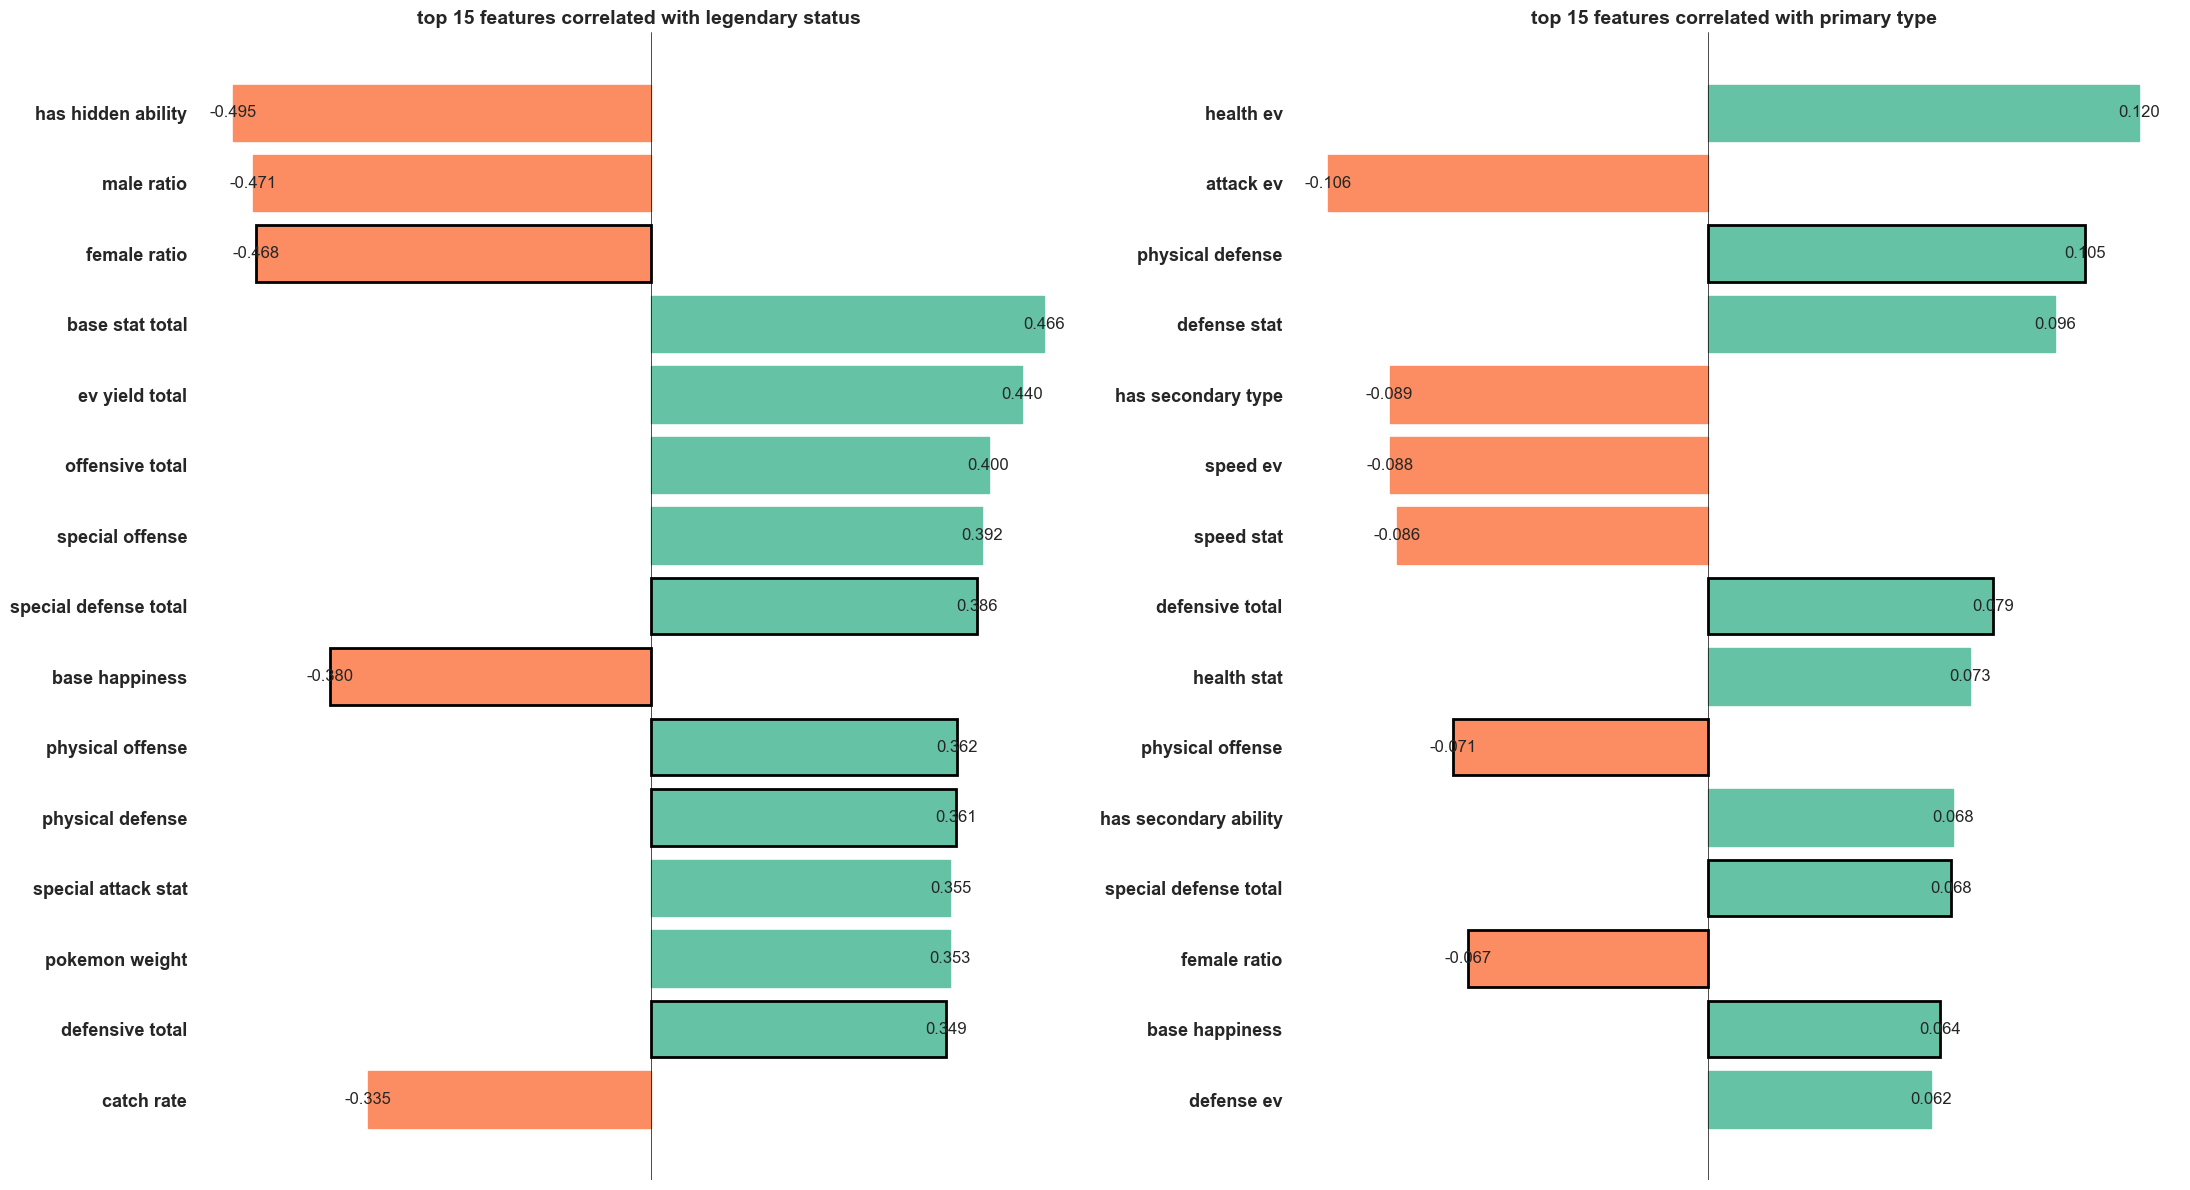

top features correlated with legendary status

positive correlations (legendary pokemon tend to have higher values):
Base Stat Total          0.465501
EV Yield Total           0.439547
Offensive Total          0.399659
Special Offense          0.391501
Special Defense Total    0.385552
Physical Offense         0.361946
Physical Defense         0.360953
Special Attack Stat      0.354513
Pokemon Weight           0.353461
Defensive Total          0.349052
Special Defense Stat     0.335005
Health Stat              0.307490
Speed Stat               0.303673
Attack Stat              0.294199
Defense Stat             0.281560
dtype: float64

negative correlations (legendary pokemon tend to have lower values):
Has Secondary Ability   -0.327457
Catch Rate              -0.335011
Base Happiness          -0.380248
Female Ratio            -0.468025
Male Ratio              -0.470983
Has Hidden Ability      -0.495474
dtype: float64

features with |correlation| > 0.3: 19
features with |correlation| > 

In [8]:
# calculate correlation with legendary status for all numeric features
legendary_correlations = df[all_numeric_features].corrwith(df['Is Legendary']).drop('Is Legendary').sort_values(ascending=False)

# encode primary type numerically for correlation analysis
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Primary Type Encoded'] = le.fit_transform(df['Primary Type'])

# calculate correlation with primary type (excluding type itself and other categorical text columns)
numeric_features_for_type = [col for col in all_numeric_features if col != 'Is Legendary']
type_correlations = df[numeric_features_for_type + ['Primary Type Encoded']].corrwith(df['Primary Type Encoded']).drop('Primary Type Encoded').sort_values(ascending=False, key=abs)

# combine top correlations for both targets
top_n = 15
top_legendary_corr = legendary_correlations.abs().sort_values(ascending=False).head(top_n)[::-1]
top_type_corr = type_correlations.abs().sort_values(ascending=False).head(top_n)[::-1]

# find overlapping features
overlap_features = set(top_legendary_corr.index) & set(top_type_corr.index)

fig, axes = plt.subplots(1, 2, figsize=(22, 12))

# left subplot: legendary status
colors_legendary = [presentation_palette[0] if legendary_correlations[feat] > 0 else presentation_palette[1] for feat in top_legendary_corr.index]
edgecolors_legendary = ['black' if feat in overlap_features else colors_legendary[i] for i, feat in enumerate(top_legendary_corr.index)]
linewidths_legendary = [2 if feat in overlap_features else 1 for feat in top_legendary_corr.index]
bars_legendary = axes[0].barh(range(top_n), [legendary_correlations[feat] for feat in top_legendary_corr.index], color=colors_legendary, edgecolor=edgecolors_legendary, linewidth=linewidths_legendary)
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels([f"{feat.lower()}" for feat in top_legendary_corr.index], fontweight='bold', fontsize=13)
axes[0].set_title(f'top {top_n} features correlated with legendary status', fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
for i, (feat, bar) in enumerate(zip(top_legendary_corr.index, bars_legendary)):
    corr_val = legendary_correlations[feat]
    axes[0].text(corr_val, i, f'{corr_val:.3f}', ha='center', va='center', fontsize=12)
axes[0].grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    axes[0].spines[spine].set_visible(False)
axes[0].axes.get_xaxis().set_visible(False)

# right subplot: primary type
colors_type = [presentation_palette[0] if type_correlations[feat] > 0 else presentation_palette[1] for feat in top_type_corr.index]
edgecolors_type = ['black' if feat in overlap_features else colors_type[i] for i, feat in enumerate(top_type_corr.index)]
linewidths_type = [2 if feat in overlap_features else 1 for feat in top_type_corr.index]
bars_type = axes[1].barh(range(top_n), [type_correlations[feat] for feat in top_type_corr.index], color=colors_type, edgecolor=edgecolors_type, linewidth=linewidths_type)
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels([f"{feat.lower()}" for feat in top_type_corr.index], fontweight='bold', fontsize=13)
axes[1].set_title(f'top {top_n} features correlated with primary type', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
for i, (feat, bar) in enumerate(zip(top_type_corr.index, bars_type)):
    corr_val = type_correlations[feat]
    axes[1].text(corr_val, i, f'{corr_val:.3f}', ha='center', va='center', fontsize=12)
axes[1].grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    axes[1].spines[spine].set_visible(False)
axes[1].axes.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig('figures/correlation/legendary_type_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# print summary statistics for both targets
print("top features correlated with legendary status")
print("\npositive correlations (legendary pokemon tend to have higher values):")
print(legendary_correlations[legendary_correlations > 0].head(top_n))
print("\nnegative correlations (legendary pokemon tend to have lower values):")
print(legendary_correlations[legendary_correlations < 0].head(top_n))
print(f"\nfeatures with |correlation| > 0.3: {len(legendary_correlations[abs(legendary_correlations) > 0.3])}")
print(f"features with |correlation| > 0.2: {len(legendary_correlations[abs(legendary_correlations) > 0.2])}")
print(f"features with |correlation| > 0.1: {len(legendary_correlations[abs(legendary_correlations) > 0.1])}")

print(f"\ntop features correlated with primary type")
print("\nstrongest correlations (positive and negative):")
print(type_correlations.abs().sort_values(ascending=False).head(top_n)[::-1])
print(f"\noverlapping features in top {top_n} for both targets:")
print(sorted(list(overlap_features)))

In [9]:
# encode categorical features for heatmap
from sklearn.preprocessing import LabelEncoder

encoded_df = df.copy()

# encode primary type
encoded_df['Primary Type Encoded'] = LabelEncoder().fit_transform(encoded_df['Primary Type'])

# encode secondary type (fillna with 'None' for encoding)
encoded_df['Secondary Type Encoded'] = LabelEncoder().fit_transform(encoded_df['Secondary Type'].fillna('None'))

# encode abilities (fillna with 'None')
encoded_df['Primary Ability Encoded'] = LabelEncoder().fit_transform(encoded_df['Primary Ability'].fillna('None'))
encoded_df['Secondary Ability Encoded'] = LabelEncoder().fit_transform(encoded_df['Secondary Ability'].fillna('None'))
encoded_df['Hidden Ability Encoded'] = LabelEncoder().fit_transform(encoded_df['Hidden Ability'].fillna('None'))

# drop original categorical columns for heatmap
heatmap_features = all_numeric_features + [
    'Primary Type Encoded', 'Secondary Type Encoded',
    'Primary Ability Encoded', 'Secondary Ability Encoded', 'Hidden Ability Encoded'
]

encoded_heatmap_df = encoded_df[heatmap_features]

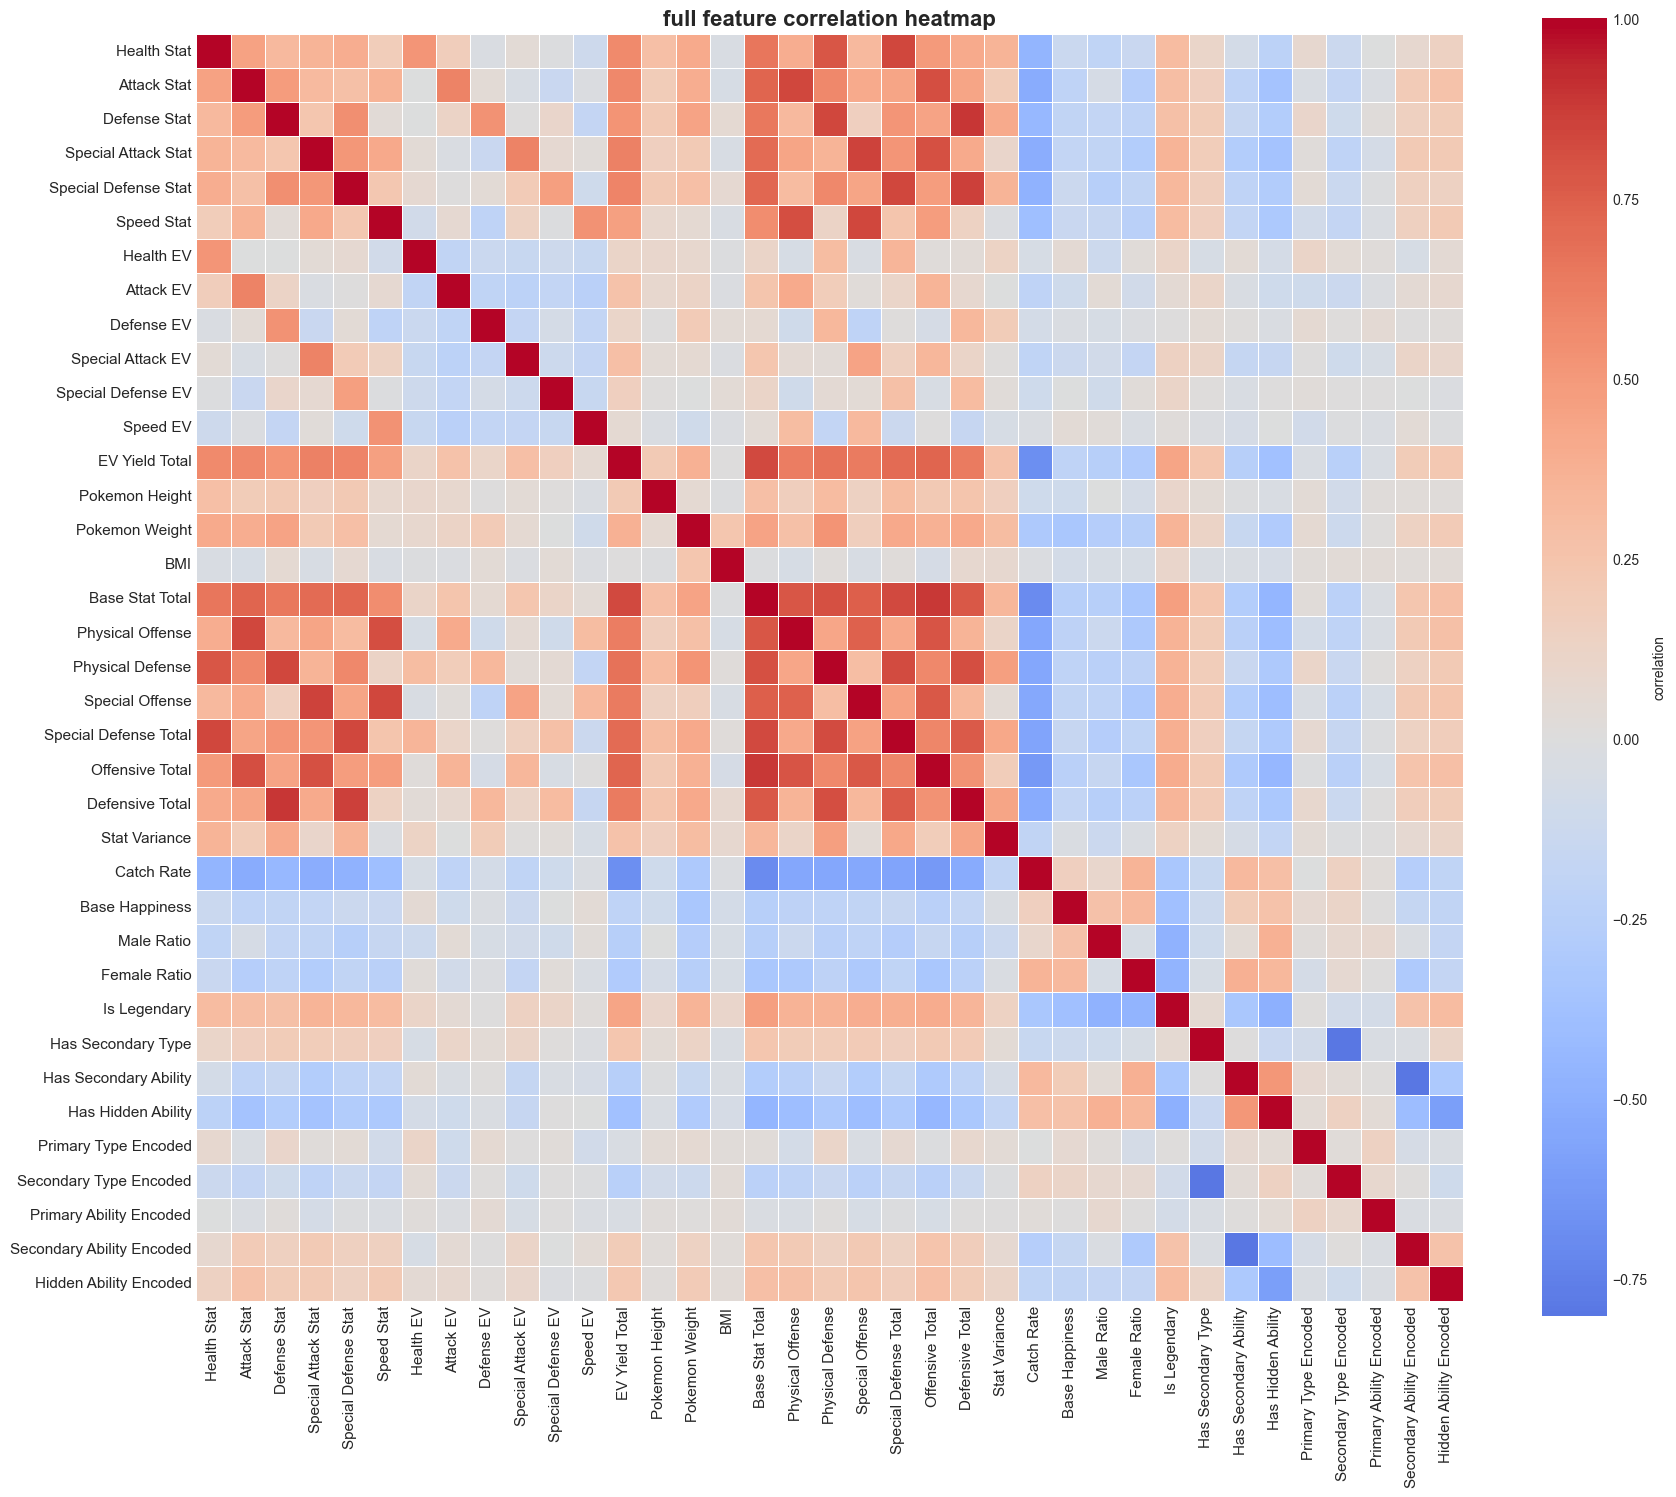

In [10]:
# plot full correlation heatmap
corr_matrix = encoded_heatmap_df.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, cbar_kws={'label': 'correlation'}, square=True)
plt.title('full feature correlation heatmap', fontsize=16, fontweight='bold')
plt.xticks(fontsize=11, rotation=90)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.savefig('figures/correlation/full_feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()